In [3]:
pip install opencv-python numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



Dominant colors (RGB) and their percentages:
RGB: [143 103  81], Percentage: 22.6%
RGB: [230 209 184], Percentage: 7.8%
RGB: [192 152 124], Percentage: 12.7%
RGB: [53 24 16], Percentage: 18.9%
RGB: [96 67 53], Percentage: 38.0%


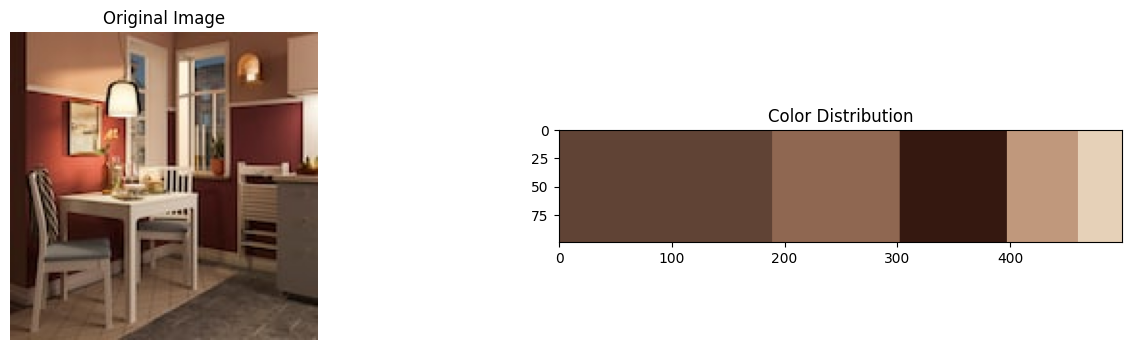

In [7]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def color_clustering(image_path, n_clusters=5):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape image data into 2D array, each row represents RGB values of a pixel
    pixels = image.reshape(-1, 3)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    
    # Get cluster centers (main colors)
    colors = kmeans.cluster_centers_
    
    # Calculate the number of pixels in each cluster
    labels = kmeans.labels_
    counts = np.bincount(labels)
    percentages = counts / len(labels) * 100
    
    # Visualize results
    plt.figure(figsize=(16, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Color bar chart
    plt.subplot(1, 2, 2)
    
    # Create color bars
    color_bars = np.zeros((100, 500, 3))
    start = 0
    
    # Sort by color proportion
    color_percent = list(zip(colors, percentages))
    color_percent.sort(key=lambda x: x[1], reverse=True)
    
    for color, percent in color_percent:
        end = start + (percent/100)*color_bars.shape[1]
        color_bars[:, int(start):int(end)] = color
        start = end
    
    plt.imshow(color_bars.astype(np.uint8))
    plt.title('Color Distribution')
    
    return colors, percentages

# Usage example
image_path = r'C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5.jpg'
dominant_colors, color_percentages = color_clustering(image_path)

# Print RGB values and percentages of each dominant color
print("\nDominant colors (RGB) and their percentages:")
for color, percentage in zip(dominant_colors, color_percentages):
    print(f"RGB: {color.astype(int)}, Percentage: {percentage:.1f}%")

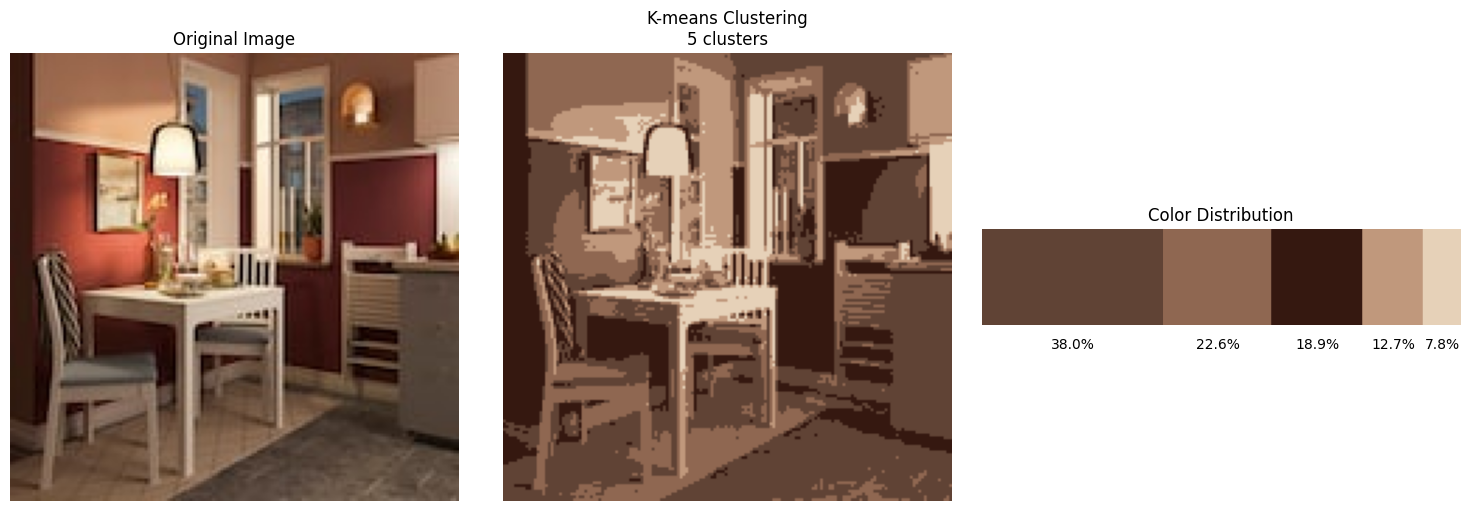

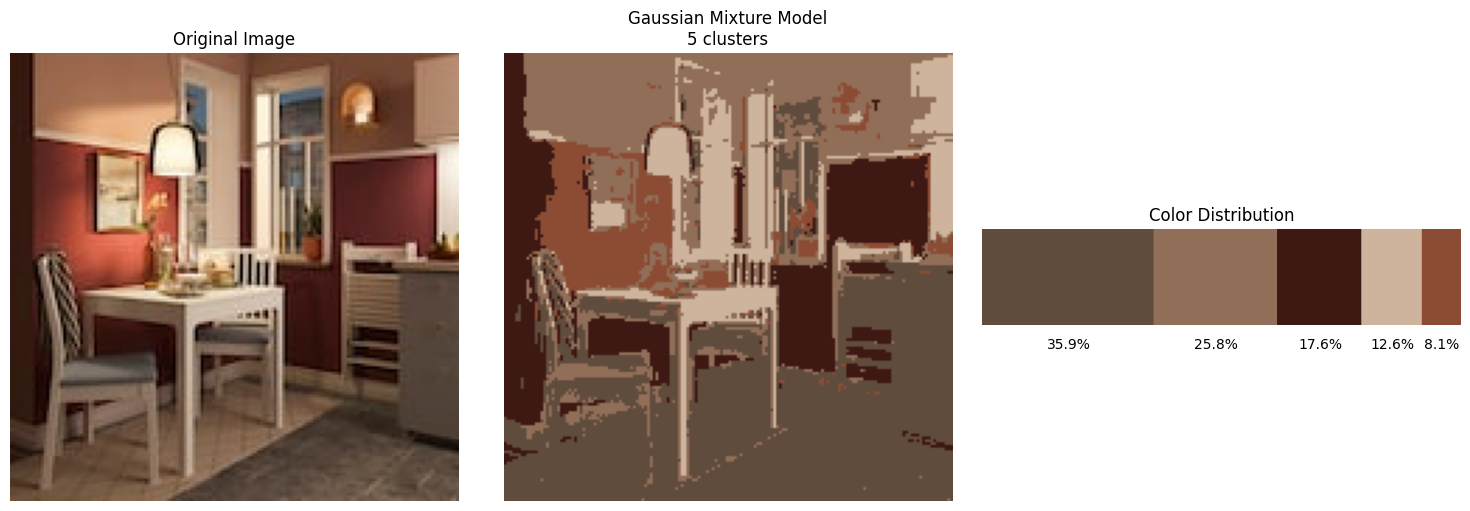

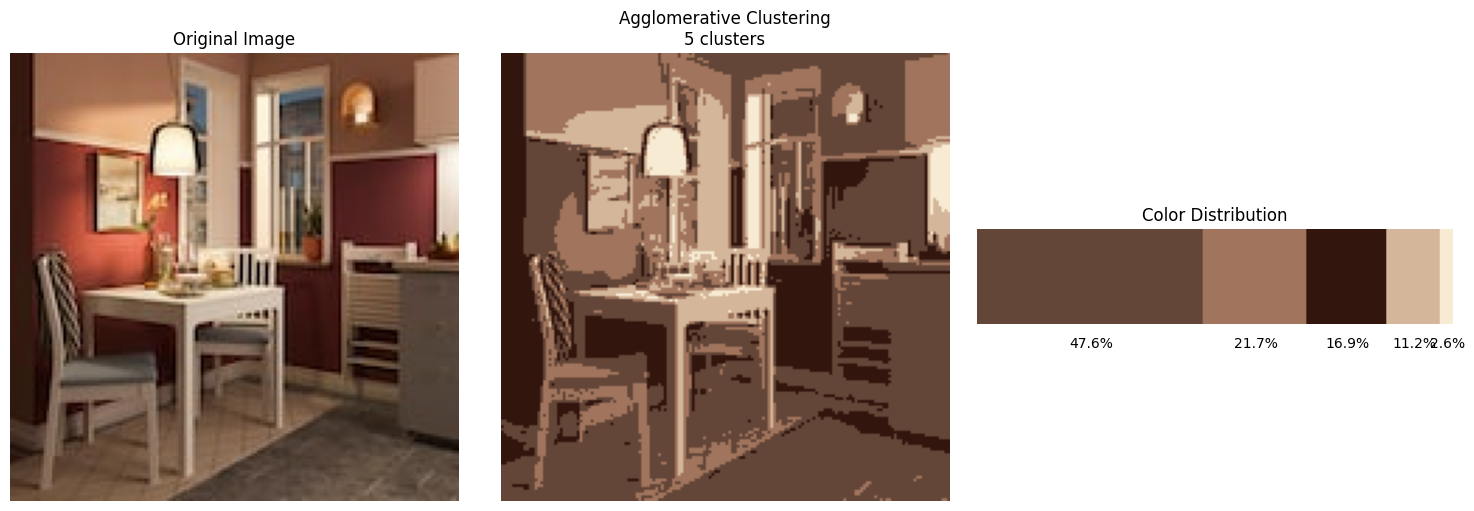

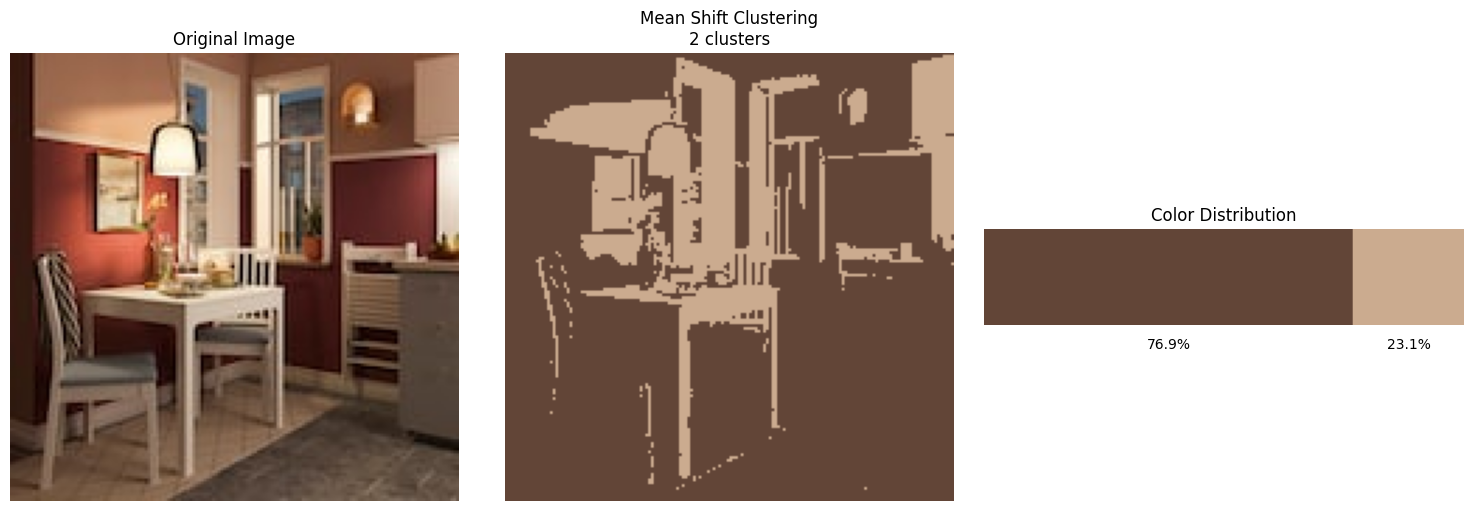

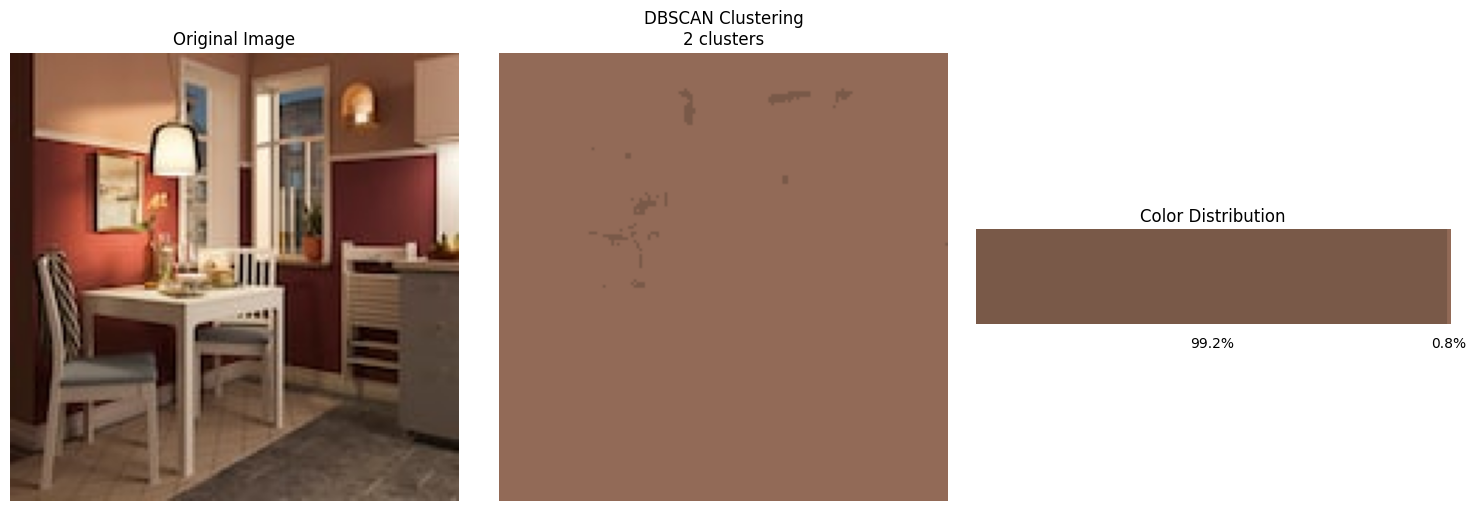

In [6]:
import numpy as np
import cv2
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_prepare_image(image_path):
    # Read and convert image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape and scale the data
    pixels = image.reshape(-1, 3)
    scaler = StandardScaler()
    pixels_scaled = scaler.fit_transform(pixels)
    
    return image, pixels, pixels_scaled, scaler

def visualize_clusters(image, pixels, labels, centers=None, title="Clustering Result"):
    # Reconstruct the image with cluster colors
    if centers is not None:
        # Use cluster centers as colors
        clustered = centers[labels].reshape(image.shape)
    else:
        # Calculate mean color for each cluster
        unique_labels = np.unique(labels)
        centers = np.array([pixels[labels == label].mean(axis=0) for label in unique_labels])
        clustered = centers[labels].reshape(image.shape)
    
    # Create color distribution bar
    unique_labels = np.unique(labels)
    percentages = np.array([(labels == label).sum() / len(labels) * 100 for label in unique_labels])
    
    # Sort colors by percentage
    sort_idx = np.argsort(percentages)[::-1]
    percentages = percentages[sort_idx]
    centers = centers[sort_idx]
    
    # Create color bar
    color_bars = np.zeros((100, 500, 3))
    start = 0
    for i, percent in enumerate(percentages):
        end = start + (percent/100)*color_bars.shape[1]
        color_bars[:, int(start):int(end)] = centers[i]
        start = end
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(clustered.astype(np.uint8))
    plt.title(f'{title}\n{len(unique_labels)} clusters')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(color_bars.astype(np.uint8))
    plt.title('Color Distribution')
    
    # Add percentage labels
    start = 0
    for i, percent in enumerate(percentages):
        plt.text(start + (percent/100)*color_bars.shape[1]/2, 120, 
                f'{percent:.1f}%', ha='center', va='center')
        start = start + (percent/100)*color_bars.shape[1]
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def analyze_multiple_clustering(image_path):
    # Load and prepare image
    image, pixels, pixels_scaled, scaler = load_and_prepare_image(image_path)
    
    # 1. K-means
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans_labels = kmeans.fit_predict(pixels)
    kmeans_centers = kmeans.cluster_centers_
    visualize_clusters(image, pixels, kmeans_labels, kmeans_centers, "K-means Clustering")
    
    # 2. Gaussian Mixture Model
    gmm = GaussianMixture(n_components=5, random_state=42)
    gmm_labels = gmm.fit_predict(pixels_scaled)
    gmm_centers = scaler.inverse_transform(gmm.means_)
    visualize_clusters(image, pixels, gmm_labels, gmm_centers, "Gaussian Mixture Model")
    
    # 3. Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=5)
    agg_labels = agg.fit_predict(pixels_scaled)
    visualize_clusters(image, pixels, agg_labels, None, "Agglomerative Clustering")
    
    # 4. Mean Shift
    bandwidth = estimate_bandwidth(pixels_scaled, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms_labels = ms.fit_predict(pixels_scaled)
    ms_centers = scaler.inverse_transform(ms.cluster_centers_)
    visualize_clusters(image, pixels, ms_labels, ms_centers, "Mean Shift Clustering")
    
    # 5. DBSCAN
    dbscan = DBSCAN(eps=0.3, min_samples=100)
    dbscan_labels = dbscan.fit_predict(pixels_scaled)
    visualize_clusters(image, pixels, dbscan_labels, None, "DBSCAN Clustering")

# Run the analysis
image_path = r'C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5.jpg'
analyze_multiple_clustering(image_path)

In [ ]:
# Best Choice: Gaussian Mixture Model (GMM)

# Reason: Furniture photos typically have subtle color gradients and shadows
# GMM can capture these variations better than K-means
# The probabilistic nature helps with smooth color transitions

In [8]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import List, Tuple

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0390445..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7556022..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11430778..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.94742703..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3301654..2.64].


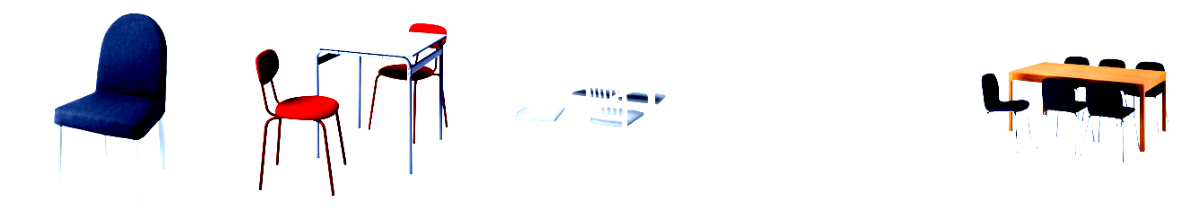

In [24]:
class ImageDataset(Dataset):
    def __init__(self, folder_path: str, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform
            
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

# Create a dataset instance
dataset = ImageDataset(r'C:\Users\admin\my_dataset')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Show some sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_batch[i].permute(1, 2, 0).numpy())
    plt.axis('off')
plt.show()

In [34]:
def extract_features(dataloader: DataLoader) -> np.ndarray:
    """
    Extract feature vectors from images
    
    Parameters:
    dataloader: image data loader
    
    Returns:
    np.ndarray: extracted feature vectors
    """
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
     
    # Remove the last fully connected layer
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.eval()
    
    features = []
    
    with torch.no_grad():
        for batch, _ in dataloader:
            # 提取特征 / Extract features
            batch_features = feature_extractor(batch)
            # 展平特征 / Flatten features
            batch_features = batch_features.squeeze()
            features.append(batch_features.numpy())
    
    return np.vstack(features)

# Extract features for all images
image_features = extract_features(dataloader)
print(f"Extracted features shape: {image_features.shape}")

Extracted features shape: (286, 512)


In [26]:
class SOM:
    def __init__(self, input_dim: int, grid_size: Tuple[int, int], learning_rate: float = 0.1):
        """
        Initialize SOM model
        """
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        
        # Randomly initialize weights
        self.weights = np.random.randn(grid_size[0], grid_size[1], input_dim)
        
    def find_bmu(self, x: np.ndarray) -> Tuple[int, int]:
        """
        Find the Best Matching Unit (BMU)
        """
        distances = np.sum((self.weights - x) ** 2, axis=2)
        return np.unravel_index(np.argmin(distances), distances.shape)
    
    def gaussian(self, c: Tuple[int, int], sigma: float) -> np.ndarray:
        """
        Calculate Gaussian neighborhood function
        """
        y, x = np.ogrid[0:self.grid_size[0], 0:self.grid_size[1]]
        return np.exp(-((x - c[1]) ** 2 + (y - c[0]) ** 2) / (2 * sigma ** 2))
    
    def train(self, data: np.ndarray, epochs: int = 100):
        """
        Train the SOM network
        """
        # Initialize sigma value
        initial_sigma = max(self.grid_size) / 2
        
        for epoch in range(epochs):
            # Calculate current sigma and learning rate
            sigma = initial_sigma * np.exp(-epoch / epochs)
            curr_lr = self.learning_rate * np.exp(-epoch / epochs)
            
            for x in data:
                # Find BMU and update weights
                bmu = self.find_bmu(x)
                g = self.gaussian(bmu, sigma)
                g = g.reshape(g.shape + (1,))
                self.weights += curr_lr * g * (x - self.weights)
                
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} completed")

# Create and train SOM
som = SOM(input_dim=image_features.shape[1], grid_size=(10, 10))
som.train(image_features)

Epoch 10/100 completed
Epoch 20/100 completed
Epoch 30/100 completed
Epoch 40/100 completed
Epoch 50/100 completed
Epoch 60/100 completed
Epoch 70/100 completed
Epoch 80/100 completed
Epoch 90/100 completed
Epoch 100/100 completed



Testing SOM size (5, 5)
Epoch 10/50 completed
Epoch 20/50 completed
Epoch 30/50 completed
Epoch 40/50 completed
Epoch 50/50 completed
Average quantization error: 138.2999374694078

Testing SOM size (10, 10)
Epoch 10/50 completed
Epoch 20/50 completed
Epoch 30/50 completed
Epoch 40/50 completed
Epoch 50/50 completed
Average quantization error: 131.10276322922854

Testing SOM size (15, 15)
Epoch 10/50 completed
Epoch 20/50 completed
Epoch 30/50 completed
Epoch 40/50 completed
Epoch 50/50 completed
Average quantization error: 129.04419519777773


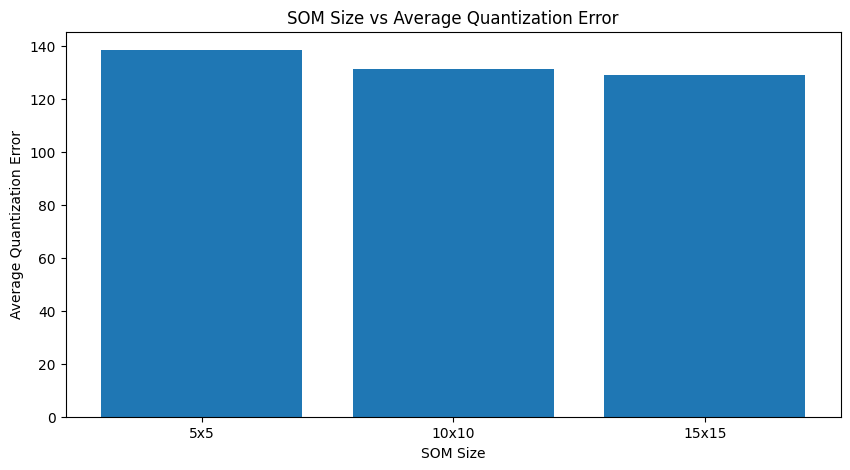

In [27]:
def test_som_sizes(features: np.ndarray, sizes: List[Tuple[int, int]], epochs: int = 50):
    """
    Test different SOM sizes for effectiveness
    """
    results = {}
    
    for size in sizes:
        print(f"\nTesting SOM size {size}")
        # Create and train SOM with different sizes
        som = SOM(input_dim=features.shape[1], grid_size=size)
        som.train(features, epochs=epochs)
        
        # Calculate quantization error
        total_error = 0
        for x in features:
            bmu = som.find_bmu(x)
            error = np.sum((x - som.weights[bmu]) ** 2)
            total_error += error
        
        avg_error = total_error / len(features)
        results[size] = avg_error
        print(f"Average quantization error: {avg_error}")
    
    return results

# Test different SOM sizes
test_sizes = [(5, 5), (10, 10), (15, 15)]
size_results = test_som_sizes(image_features, test_sizes)

# Plot results
plt.figure(figsize=(10, 5))
plt.bar([f"{s[0]}x{s[1]}" for s in size_results.keys()], list(size_results.values()))
plt.title('SOM Size vs Average Quantization Error')
plt.xlabel('SOM Size')
plt.ylabel('Average Quantization Error')
plt.show()

In [19]:
import pickle

def save_som(som: SOM, filepath: str) -> None:
    """
    Save the trained SOM model to a file
    
    Parameters:
    som: trained SOM model
    filepath: save path
    """
    with open(filepath, 'wb') as f:
        pickle.dump({
            'weights': som.weights,
            'grid_size': som.grid_size,
            'input_dim': som.input_dim,
            'learning_rate': som.learning_rate
        }, f)
    print(f"Model saved to: {filepath}")

def load_som(filepath: str) -> SOM:
    """
    Load SOM model from file
    
    Parameters:
    filepath: model file path
    
    Returns:
    loaded SOM model
    """
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # Create new SOM instance
    som = SOM(input_dim=data['input_dim'], 
              grid_size=data['grid_size'], 
              learning_rate=data['learning_rate'])
    som.weights = data['weights']
    
    return som

# Test save and load functions
save_path = "trained_som.pkl"
save_som(som, save_path)

# Load saved model
loaded_som = load_som(save_path)

# Verify if the loaded model is correct
test_input = image_features[0]
original_bmu = som.find_bmu(test_input)
loaded_bmu = loaded_som.find_bmu(test_input)

print("Original model BMU:", original_bmu)
print("Loaded model BMU:", loaded_bmu)
print("BMU match:", original_bmu == loaded_bmu)

Model saved to: trained_som.pkl
Original model BMU: (9, 5)
Loaded model BMU: (9, 5)
BMU match: True


PCA using SOM weights only:


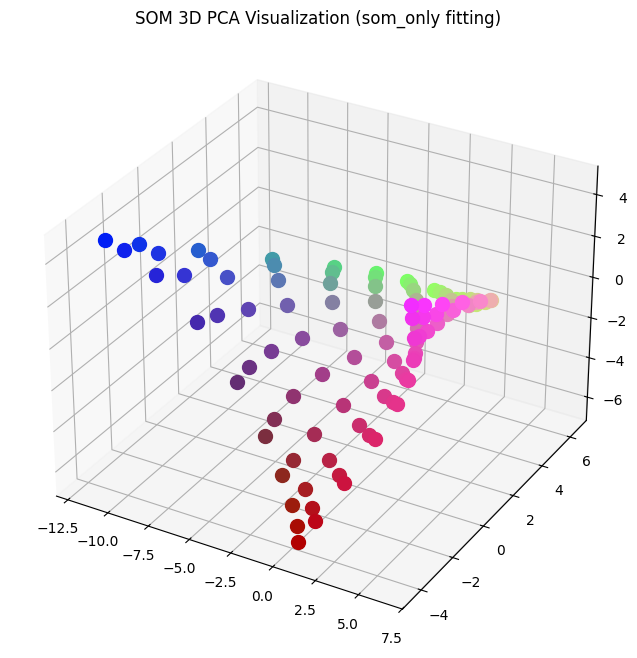

PCA using full training set:


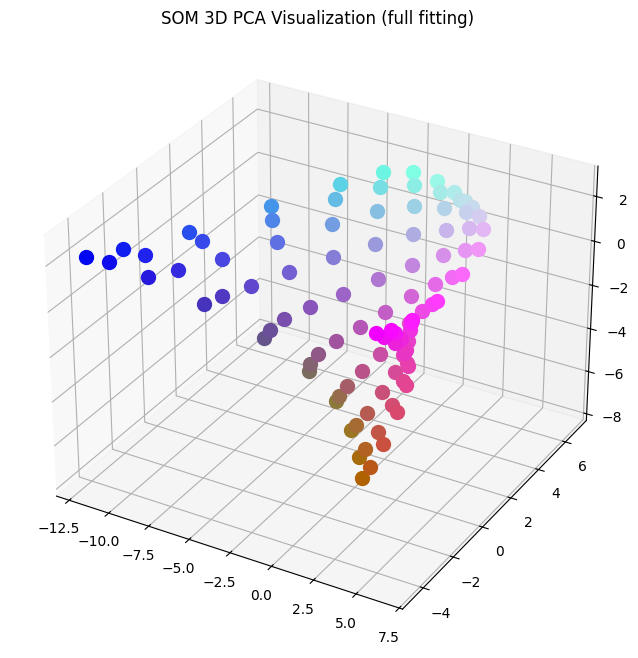

In [28]:
from sklearn.decomposition import PCA

def visualize_som_pca(som: SOM, training_data: np.ndarray, method: str = 'som_only') -> None:
    """
    
    Reduce SOM weights to 3D using PCA and visualize
    
    Parameters:
    som: trained SOM model
    training_data: training data
    method: PCA fitting method
    """
    # Initialize PCA
    pca = PCA(n_components=3)
    
    if method == 'full':
        # Fit PCA on entire training set
        pca.fit(training_data)
    else:
        # Fit PCA only on SOM weights
        weights_2d = som.weights.reshape(-1, som.input_dim)
        pca.fit(weights_2d)
    
    # Transform SOM weights
    weights_2d = som.weights.reshape(-1, som.input_dim)
    weights_3d = pca.transform(weights_2d)
    
    
    # Normalize to [0,1] range for RGB color display
    weights_3d_normalized = (weights_3d - weights_3d.min(axis=0)) / (weights_3d.max(axis=0) - weights_3d.min(axis=0))
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each neuron
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            idx = i * som.grid_size[1] + j
            color = weights_3d_normalized[idx]
            ax.scatter(weights_3d[idx, 0], 
                      weights_3d[idx, 1], 
                      weights_3d[idx, 2], 
                      c=[color], 
                      s=100)
    
    ax.set_title(f'SOM 3D PCA Visualization ({method} fitting)')
    plt.show()

# Test both PCA methods
print("PCA using SOM weights only:")
visualize_som_pca(som, image_features, method='som_only')

print("PCA using full training set:")
visualize_som_pca(som, image_features, method='full')

Displaying SOM image mapping:


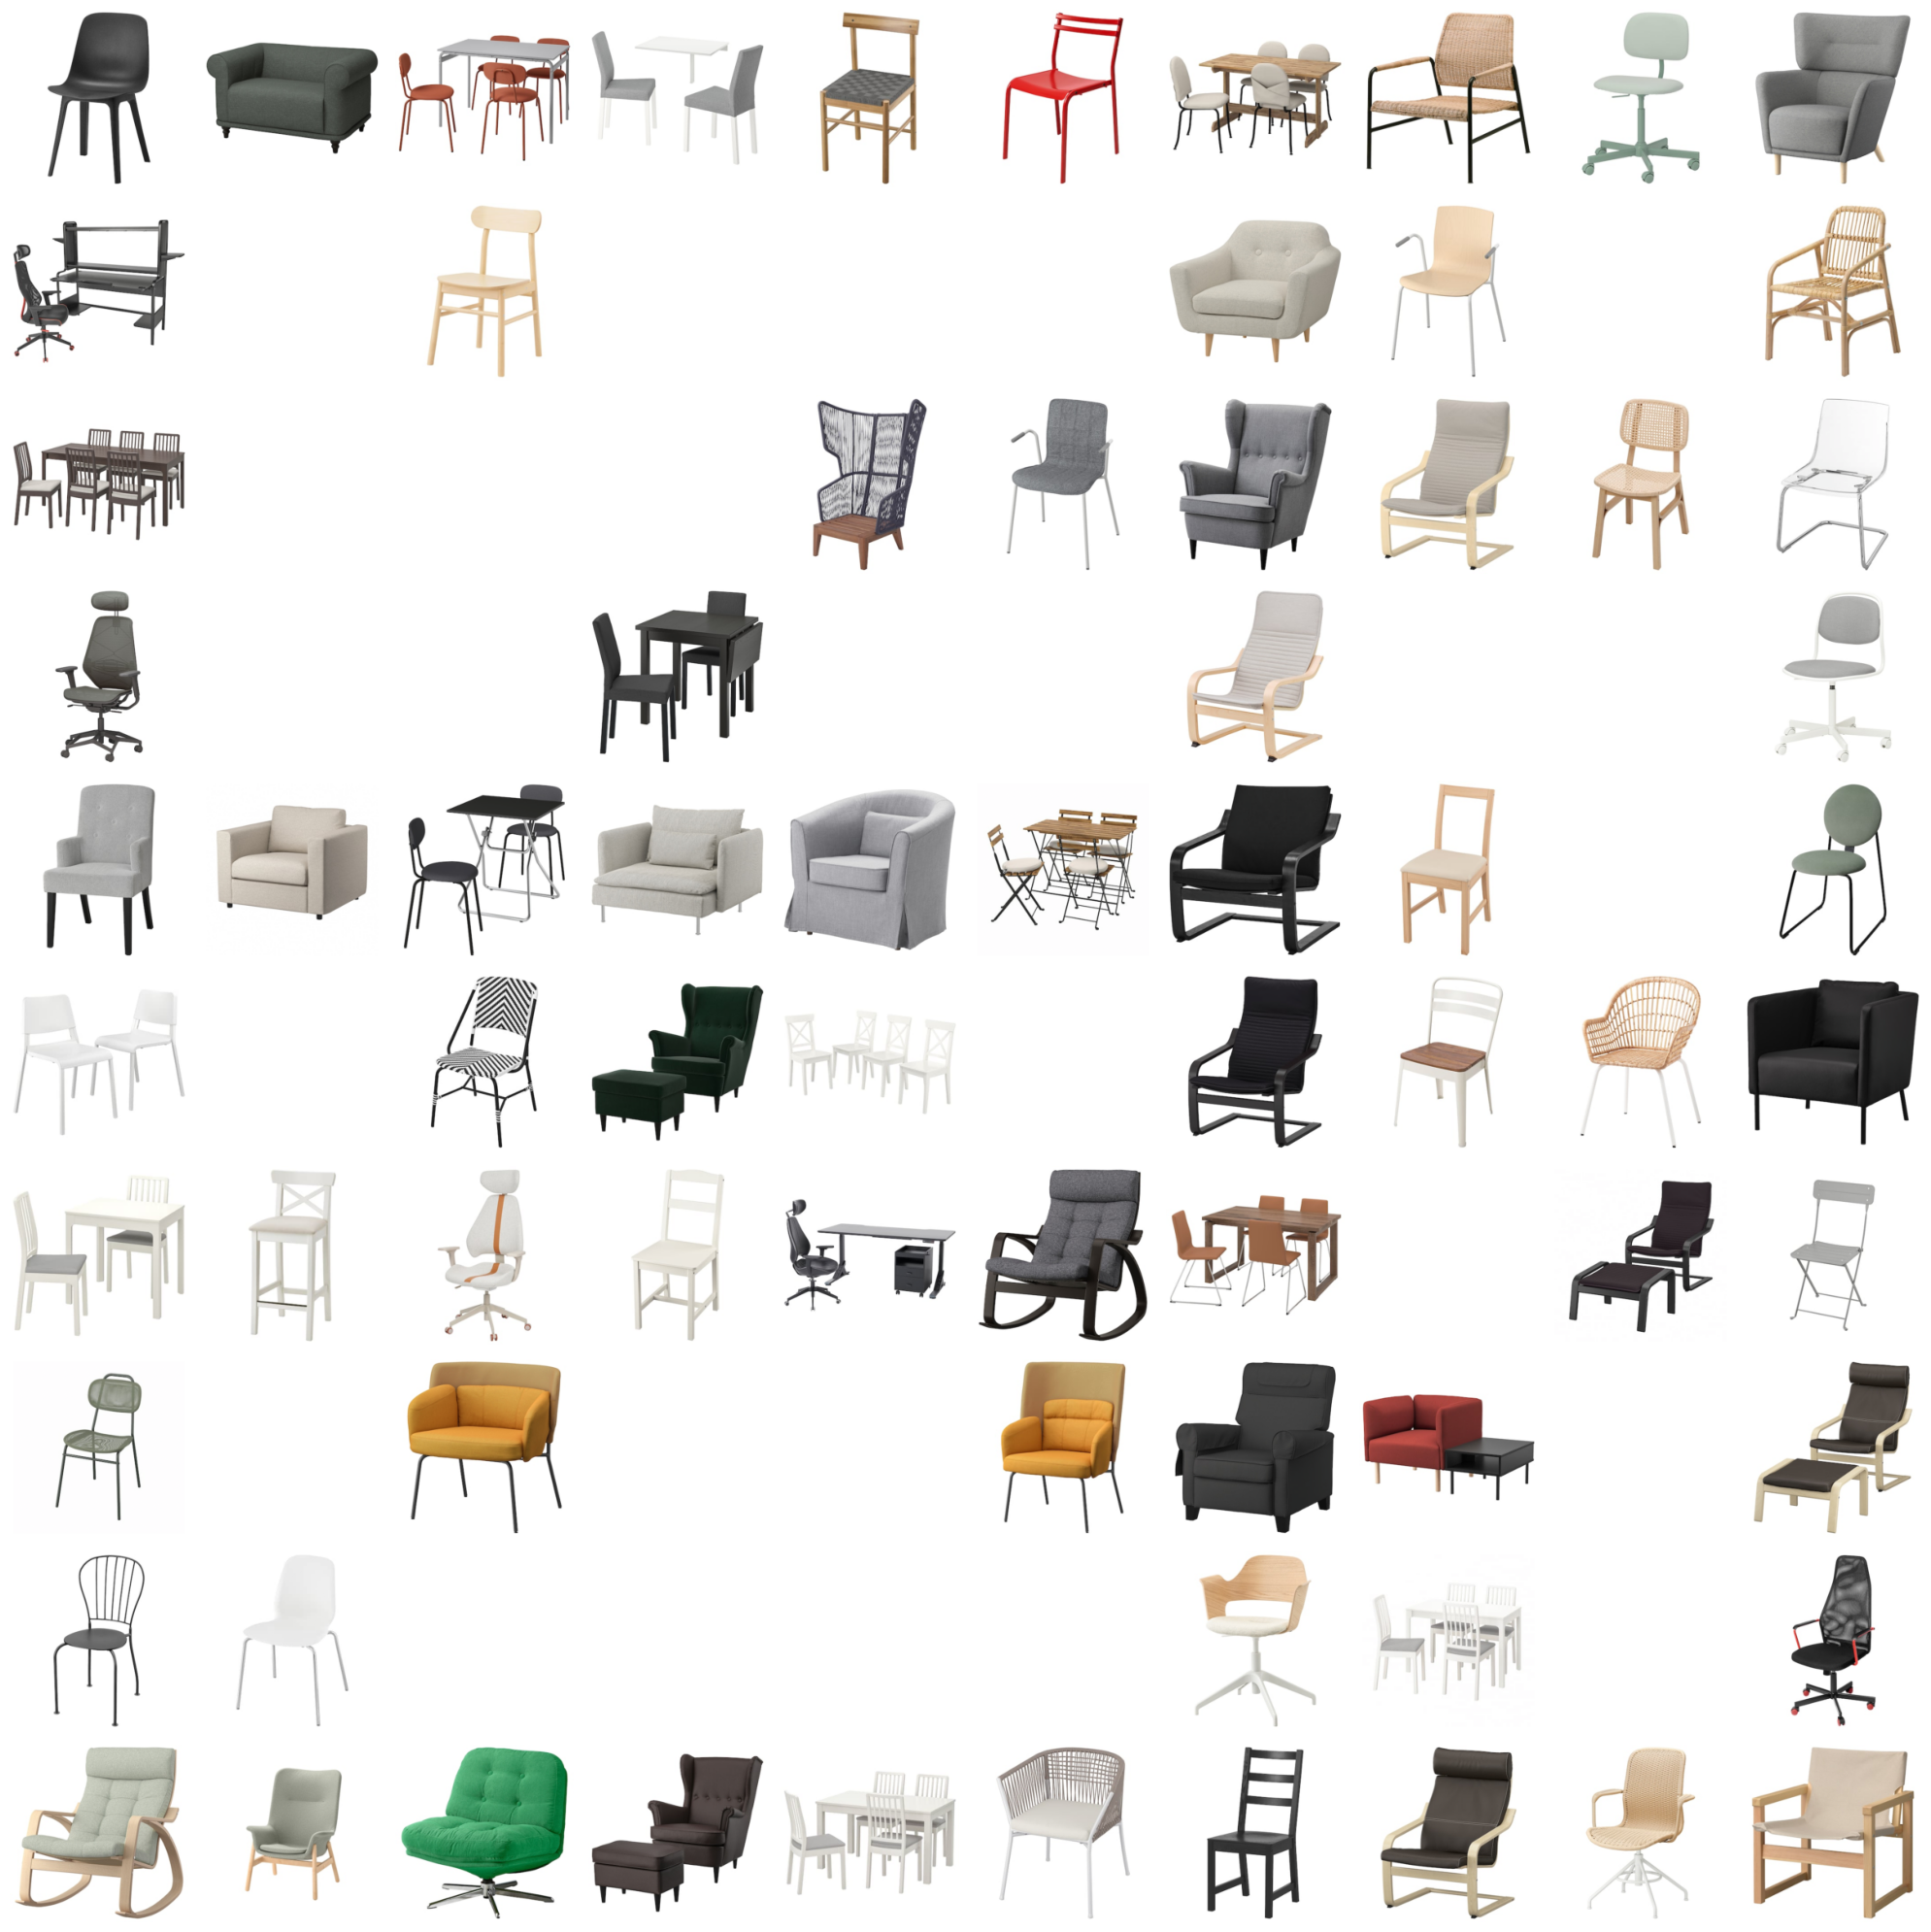

Displaying sample activation map:


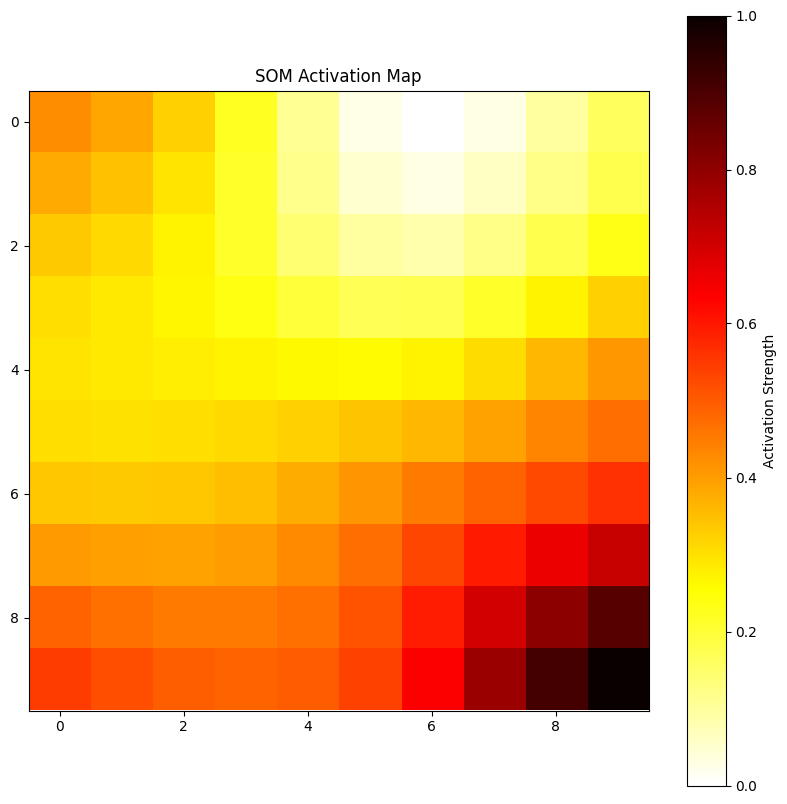

Creating image grid:
Distribution of images in each cell:
Position (0, 6): 10 images
Position (9, 0): 14 images
Position (0, 9): 15 images
Position (0, 0): 15 images
Position (0, 5): 5 images
Position (4, 9): 10 images
Position (2, 6): 2 images
Position (0, 1): 2 images
Position (1, 9): 3 images
Position (3, 9): 7 images
Position (9, 9): 17 images
Position (4, 4): 4 images
Position (9, 3): 12 images
Position (6, 8): 1 images
Position (6, 0): 3 images
Position (0, 7): 2 images
Position (3, 0): 6 images
Position (4, 2): 3 images
Position (7, 6): 3 images
Position (4, 6): 2 images
Position (6, 6): 1 images
Position (7, 7): 4 images
Position (9, 4): 6 images
Position (9, 7): 4 images
Position (2, 8): 2 images
Position (0, 2): 11 images
Position (4, 0): 14 images
Position (6, 5): 4 images
Position (1, 0): 7 images
Position (1, 7): 1 images
Position (7, 0): 2 images
Position (0, 8): 1 images
Position (9, 2): 3 images
Position (7, 5): 5 images
Position (9, 5): 3 images
Position (1, 2): 1 imag

In [35]:
def visualize_som_with_images(som: SOM, images: List[np.ndarray], features: np.ndarray) -> None:
    
    # Create a dictionary to store best matching images for each cell
    cell_images = {}
    
    # Find BMU for each image
    for idx, (feature, image) in enumerate(zip(features, images)):
        bmu = som.find_bmu(feature)
        if bmu not in cell_images:
            cell_images[bmu] = []
        cell_images[bmu].append((image, np.sum((feature - som.weights[bmu]) ** 2)))
    
    # Create image grid
    fig, axes = plt.subplots(som.grid_size[0], som.grid_size[1], 
                            figsize=(20, 20))
    
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            if (i, j) in cell_images:
                # Select the closest image
                best_image = min(cell_images[(i, j)], key=lambda x: x[1])[0]
                axes[i, j].imshow(best_image)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_activation_map(som: SOM, input_feature: np.ndarray) -> None:
   
    # Calculate distances for all units
    distances = np.zeros(som.grid_size)
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            distances[i, j] = np.sum((som.weights[i, j] - input_feature) ** 2)
    
    # Normalize distances
    distances = (distances - distances.min()) / (distances.max() - distances.min())
    
    # Create heatmap
    plt.figure(figsize=(10, 10))
    plt.imshow(distances, cmap='hot_r')
    plt.colorbar(label='Activation Strength')
    plt.title('SOM Activation Map')
    plt.show()

# Create a function to generate image grid
def create_image_grid(som: SOM, images: List[np.ndarray], features: np.ndarray) -> np.ndarray:
    
    # Create dictionary to store images for each cell
    cell_images = {}
    
    # Find BMU for each image
    for idx, (feature, image) in enumerate(zip(features, images)):
        bmu = som.find_bmu(feature)
        if bmu not in cell_images:
            cell_images[bmu] = []
        cell_images[bmu].append(image)
    
    return cell_images

# Test these functions
original_images = []
for batch, _ in dataloader:
    for img in batch:
        # De-normalize images
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        original_images.append(img.permute(1, 2, 0).numpy())

# Display SOM with images
print("Displaying SOM image mapping:")
visualize_som_with_images(som, original_images, image_features)

# Display sample activation map
print("Displaying sample activation map:")
sample_feature = image_features[0]
visualize_activation_map(som, sample_feature)

# Create complete image grid
print("Creating image grid:")
image_grid = create_image_grid(som, original_images, image_features)

# Print number of images in each cell
print("Distribution of images in each cell:")
for pos, images in image_grid.items():
    print(f"Position {pos}: {len(images)} images")

In [36]:
def visualize_som_with_images(som: SOM, images: List[np.ndarray], features: np.ndarray) -> None:
    """
    Display SOM grid with best matching images for each unit, empty units show closest images
    
    Parameters:
    som: trained SOM model
    images: list of original images
    features: image features
    """
    # Create a dictionary to store best matching images for each cell
    cell_images = {}
    
    # Find BMU for each image
    for idx, (feature, image) in enumerate(zip(features, images)):
        bmu = som.find_bmu(feature)
        if bmu not in cell_images:
            cell_images[bmu] = []
        cell_images[bmu].append((image, np.sum((feature - som.weights[bmu]) ** 2)))
    
    # Create image grid
    fig, axes = plt.subplots(som.grid_size[0], som.grid_size[1], 
                            figsize=(20, 20))
    
    # Calculate distances between all units
    unit_distances = {}
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            if (i, j) not in cell_images:
                
                # Calculate distances from this empty unit to all other units
                distances = []
                for ni in range(som.grid_size[0]):
                    for nj in range(som.grid_size[1]):
                        if (ni, nj) in cell_images:
                            dist = np.sum((som.weights[i, j] - som.weights[ni, nj]) ** 2)
                            distances.append(((ni, nj), dist))
                if distances:
                    # Find the closest non-empty unit
                    closest_unit = min(distances, key=lambda x: x[1])[0]
                    unit_distances[(i, j)] = closest_unit
    
    # Display images
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            if (i, j) in cell_images:
                # Display best matching image for this unit
                best_image = min(cell_images[(i, j)], key=lambda x: x[1])[0]
                axes[i, j].imshow(best_image)
                axes[i, j].set_title(f'Original', fontsize=8)
            else:
                # Display image from closest non-empty unit
                if (i, j) in unit_distances:
                    closest_unit = unit_distances[(i, j)]
                    best_image = min(cell_images[closest_unit], key=lambda x: x[1])[0]
                    axes[i, j].imshow(best_image, alpha=0.5)  # Use transparency
                    axes[i, j].set_title(f'Closest to {closest_unit}', fontsize=8)
            
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

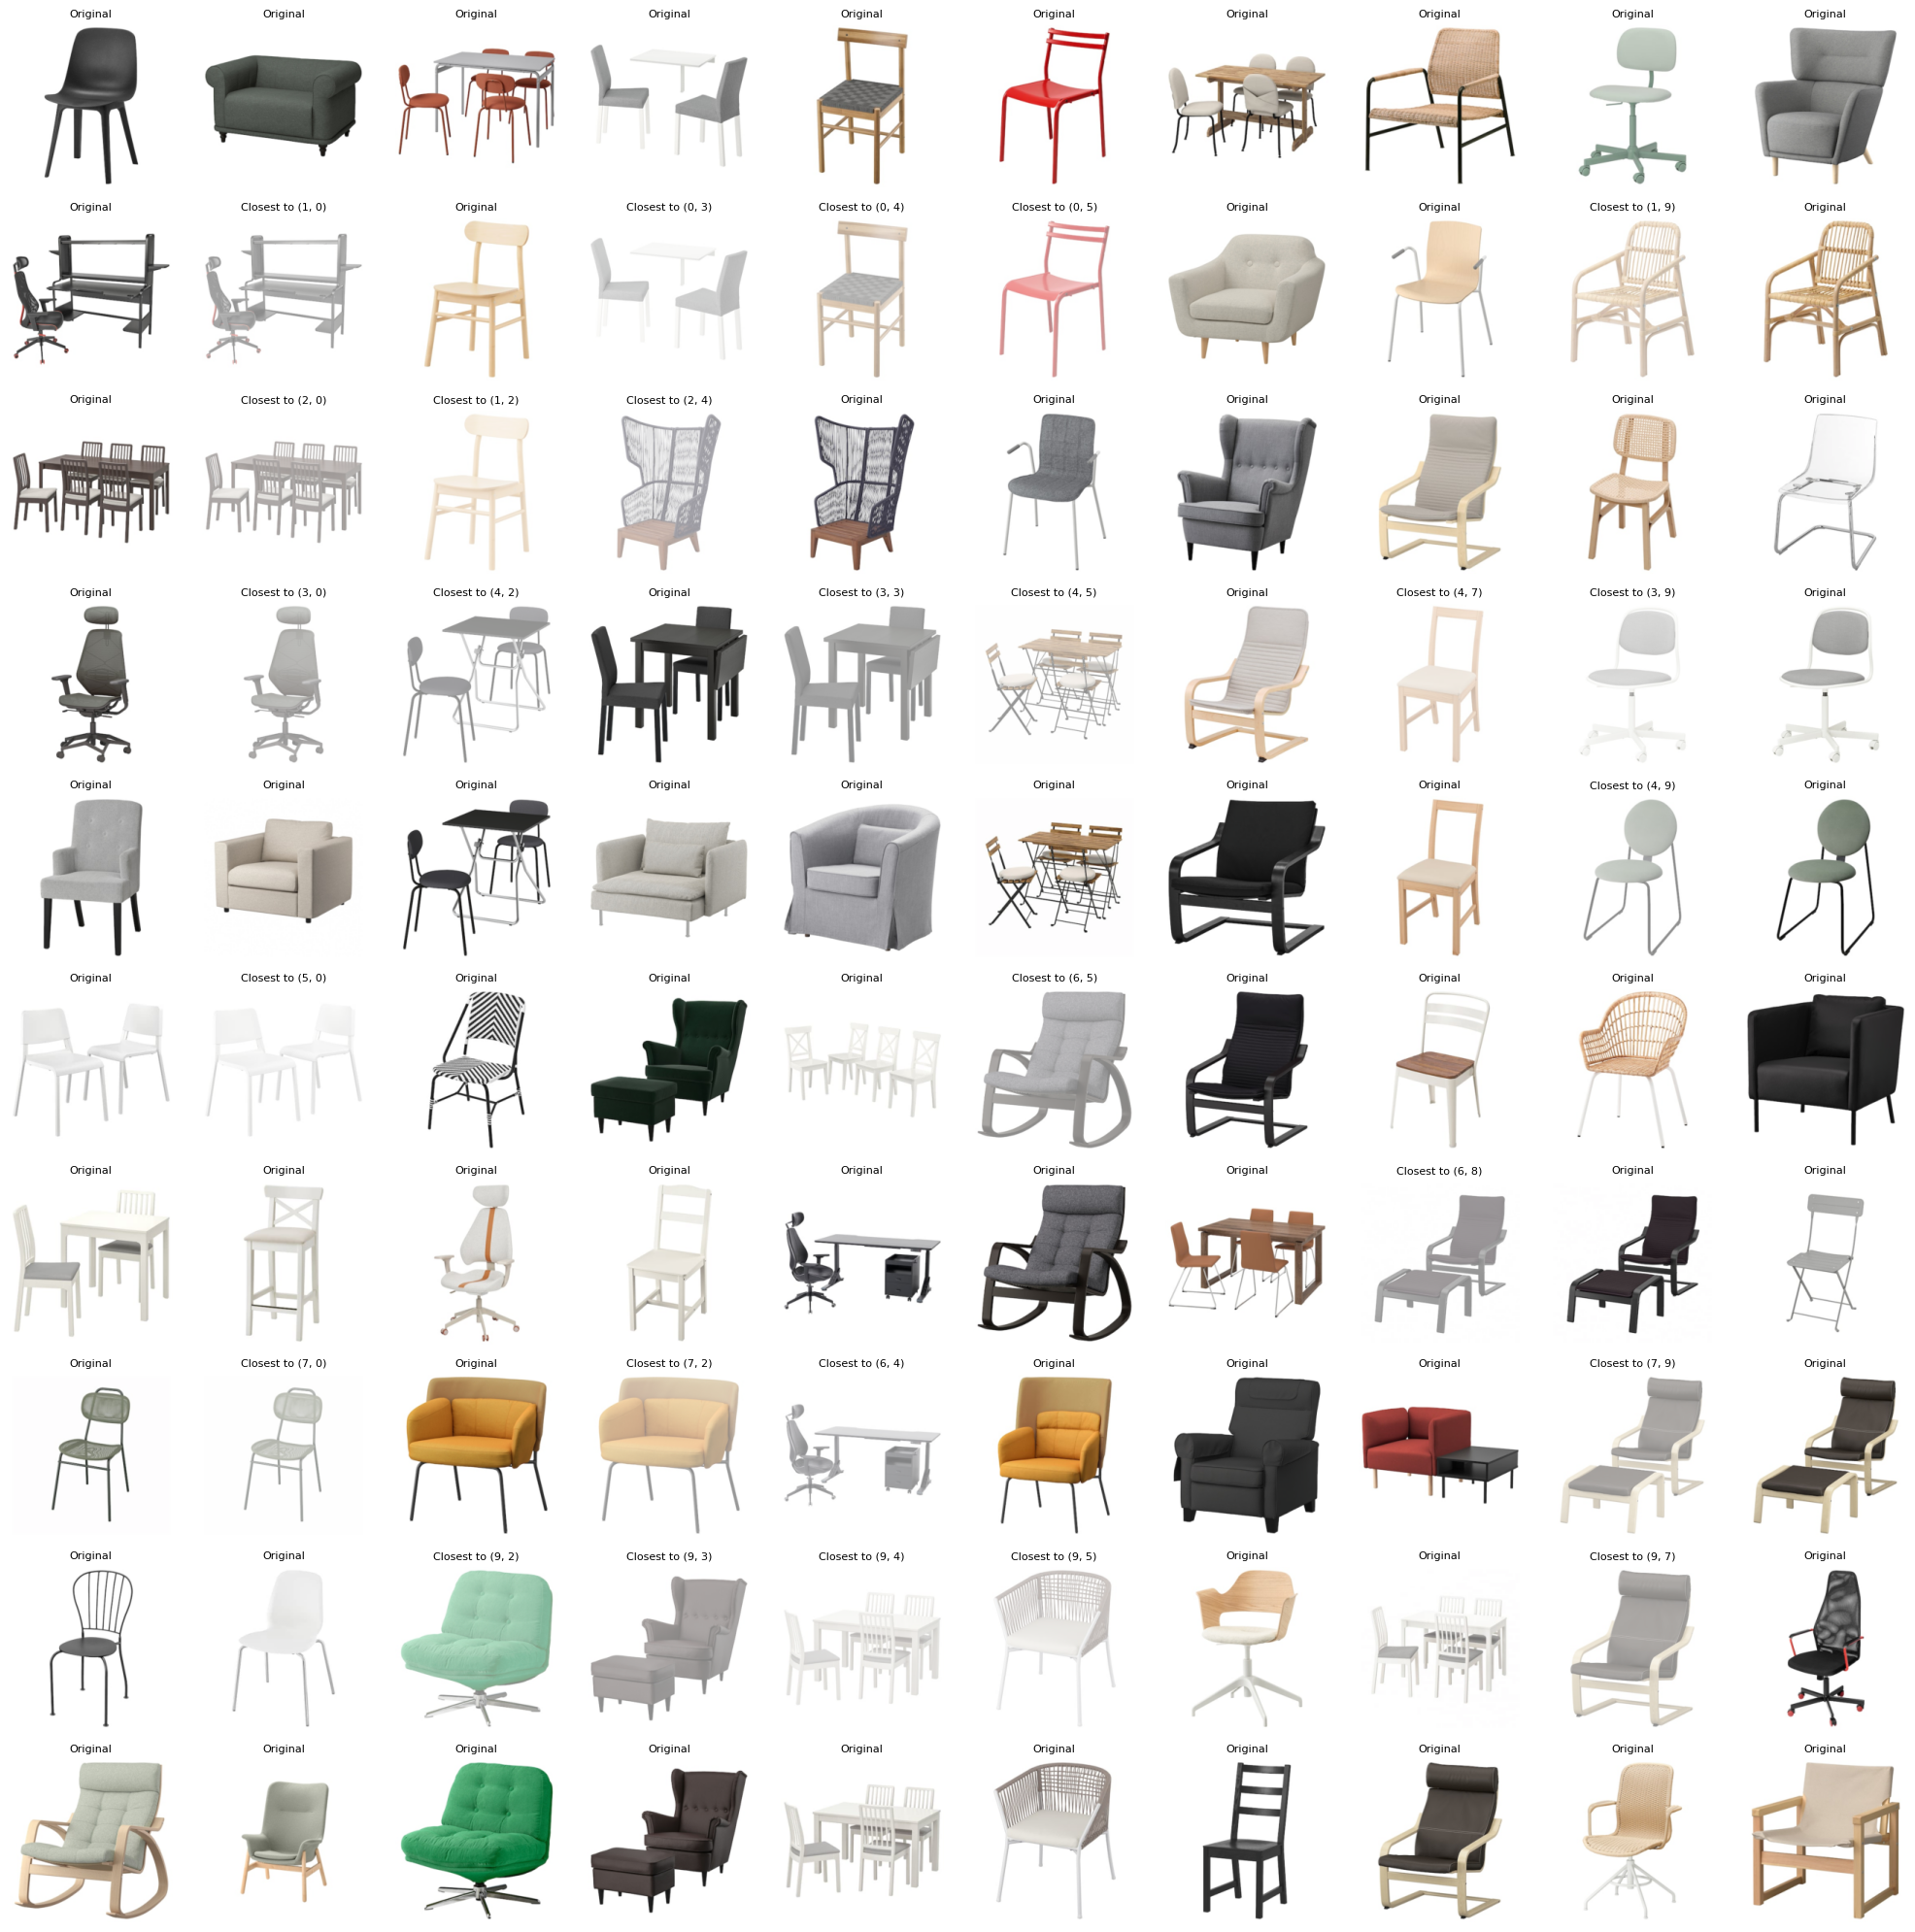

In [37]:
visualize_som_with_images(som, original_images, image_features)

In [40]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import re
import numpy as np

def clean_text(text: str) -> str:
   
    text = str(text)
    text = ' '.join(text.split())
    text = re.sub(r'[^a-zA-Z0-9\s\.]', '', text)
    return text.strip()

In [42]:
# Read CSV and process text
df = pd.read_csv(r'D:\Admin\Desktop\RC11\数据爬取\chair.csv')
texts = df.iloc[:, 9].tolist()  # Get the tenth column
texts = [clean_text(text) for text in texts if pd.notna(text)]

print("Cleaned text samples:")
print(texts[:3])
print(f"Total number of texts: {len(texts)}")

Cleaned text samples:
['Easy to keep clean by just wiping with a damp cloth.The safety castors have a pressuresensitive brake mechanism that keeps the chair in place when you stand up and releases automatically when you sit down.', 'You can stack the chairs so they take less space when youre not using them.DesignerMarcus Arvonen', 'A range of various seat cushions makes it easy to change the look of your PONG and your living room.The high back gives good support for your neck.Layerglued bent oak gives comfortable resilience.10 year guarantee. Read about the terms in the guarantee brochure.DesignerIKEA of SwedenNoboru Nakamura']
Total number of texts: 276


In [44]:
class TextDataset(Dataset):
    def __init__(self, texts: list):
        self.texts = texts
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = 128
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'text': text
        }

# Create dataset and dataloader
text_dataset = TextDataset(texts)
text_dataloader = DataLoader(text_dataset, batch_size=16, shuffle=True)

In [46]:
def extract_text_features(dataloader: DataLoader) -> np.ndarray:
    """
    
    Extract feature vectors from product descriptions
    """
    model = AutoModel.from_pretrained('bert-base-uncased')
    model.eval()
    
    features = []
    original_texts = []
    
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            mask = batch['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            batch_features = (outputs.last_hidden_state * mask).sum(1) / mask.sum(1)
            features.append(batch_features.numpy())
            original_texts.extend(batch['text'])
    
    return np.vstack(features), original_texts

# Extract text features
text_features, original_texts = extract_text_features(text_dataloader)
print(f"Text features shape: {text_features.shape}")

Text features shape: (276, 768)


In [47]:
# Train SOM
text_som = SOM(input_dim=text_features.shape[1], grid_size=(10, 10))
text_som.train(text_features)

Epoch 10/100 completed
Epoch 20/100 completed
Epoch 30/100 completed
Epoch 40/100 completed
Epoch 50/100 completed
Epoch 60/100 completed
Epoch 70/100 completed
Epoch 80/100 completed
Epoch 90/100 completed
Epoch 100/100 completed


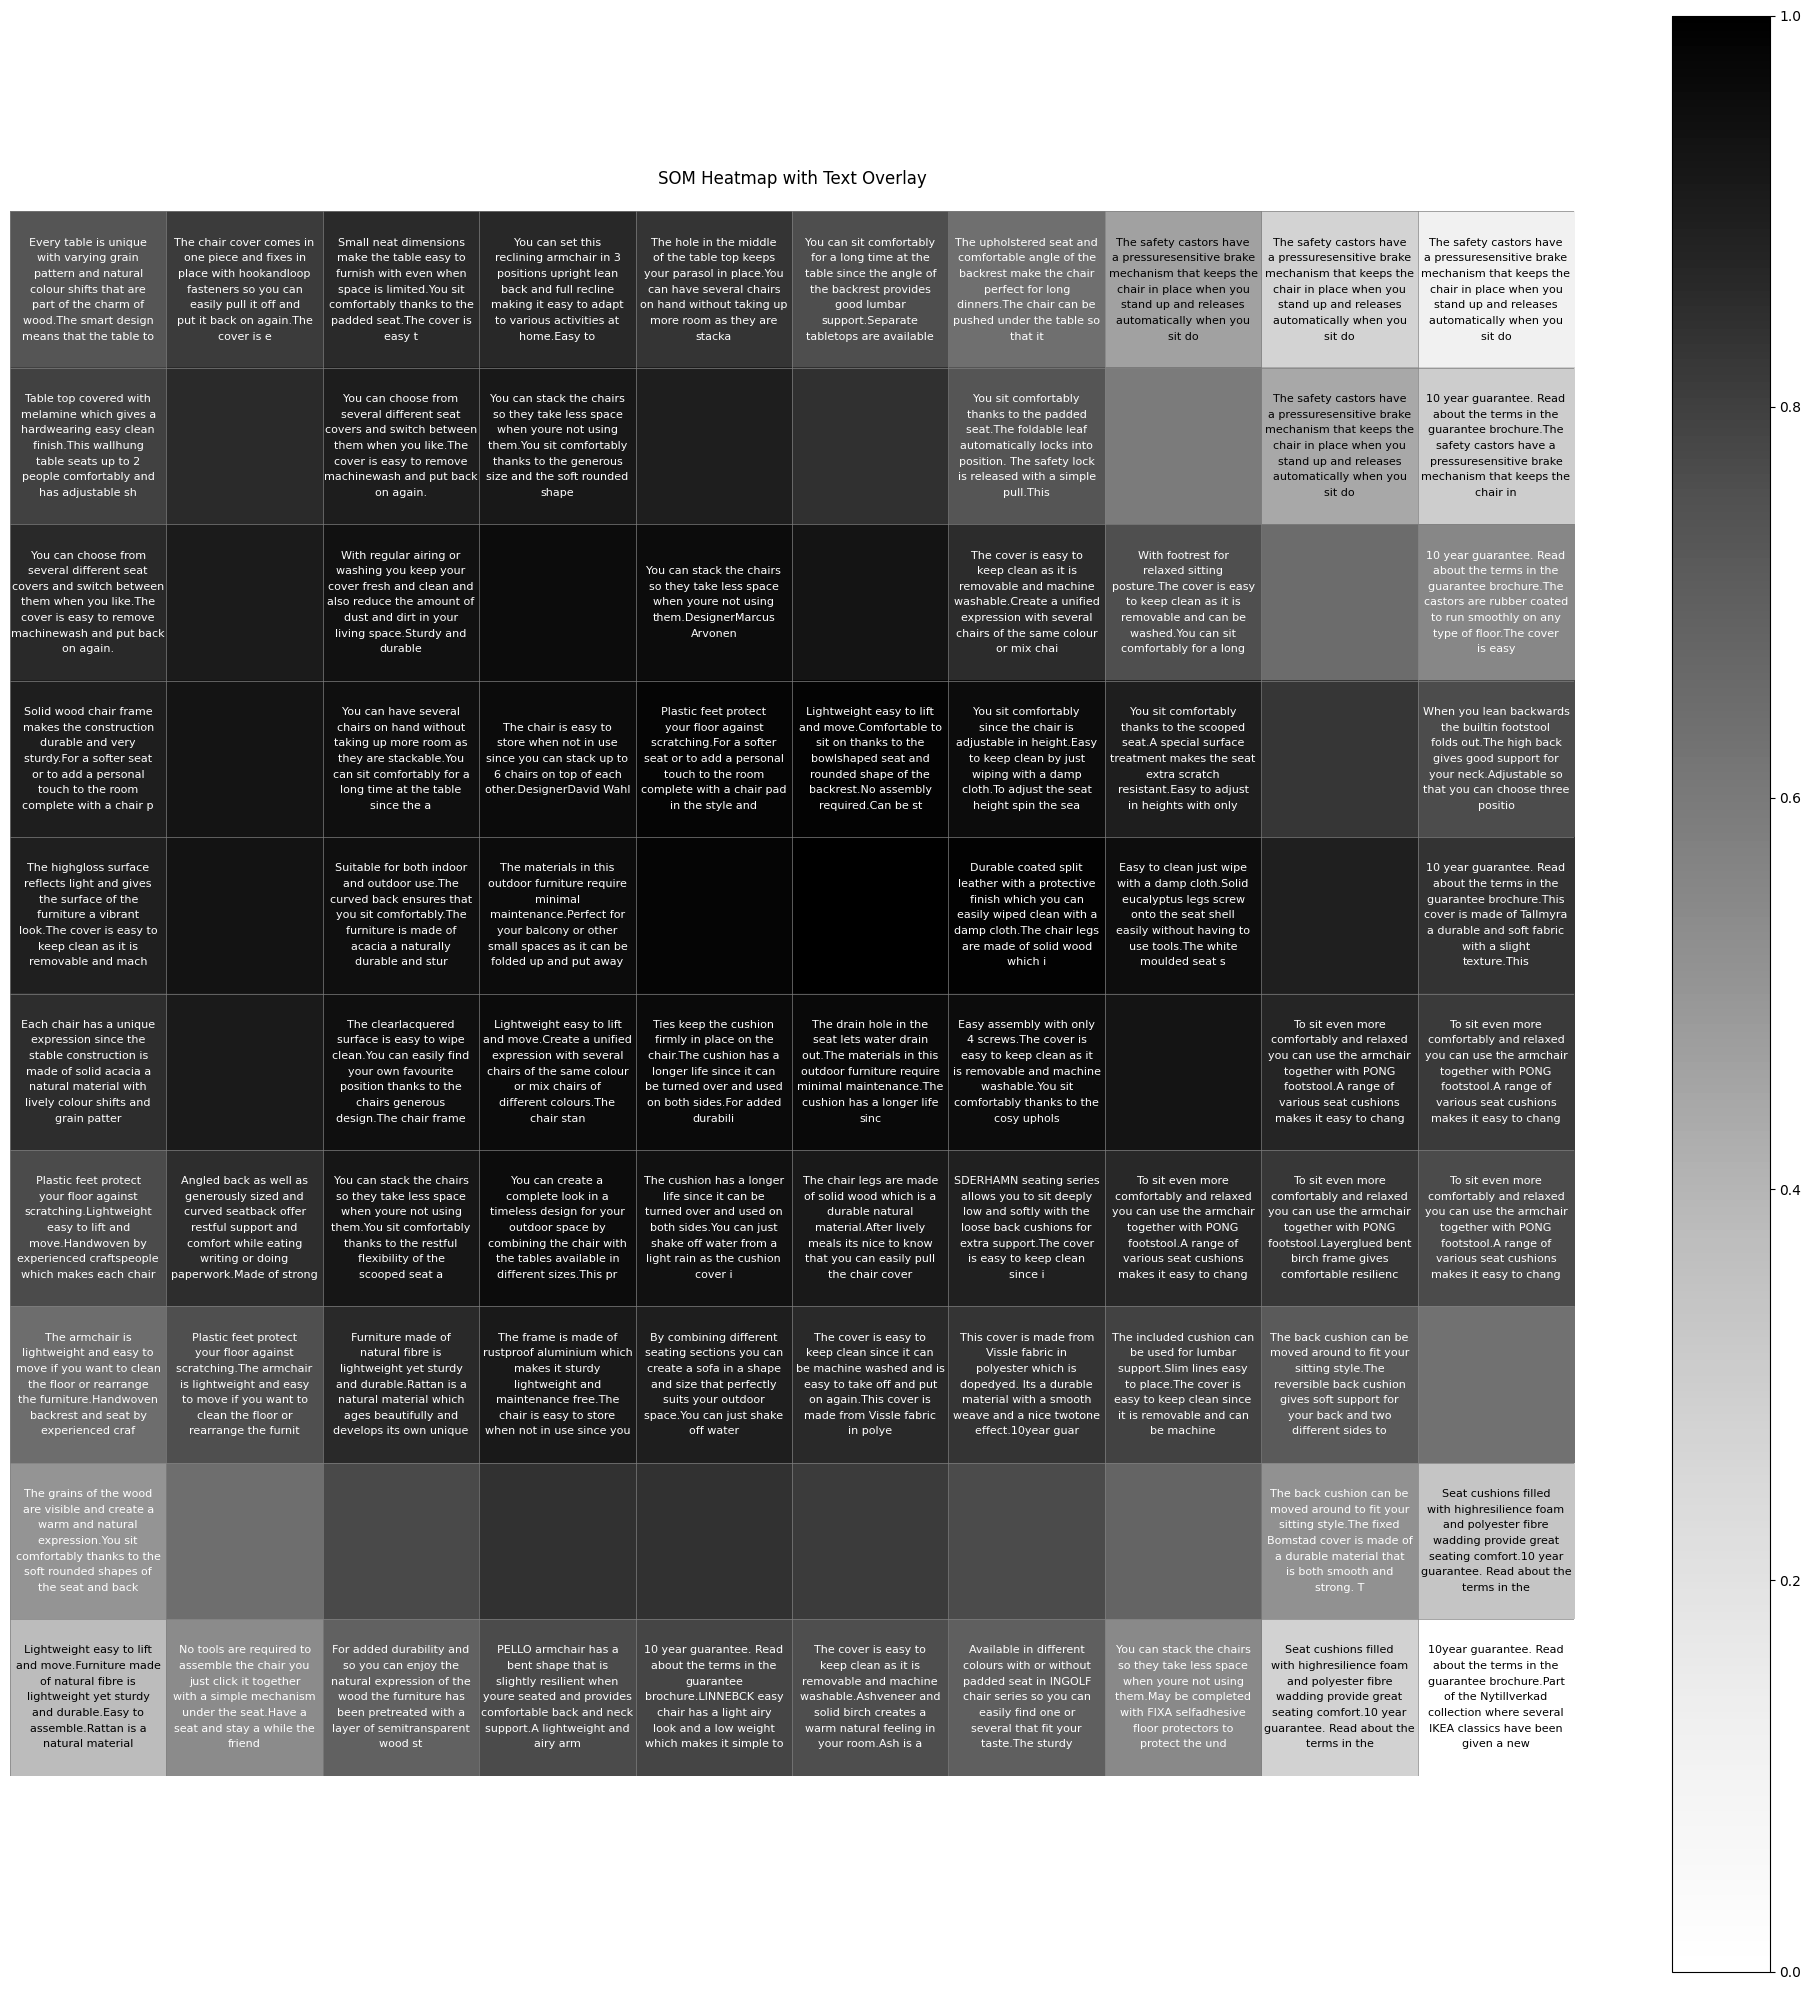

In [74]:
def visualize_som_combined(som: SOM, texts: list, features: np.ndarray) -> None:
    """
    Display SOM heatmap with text overlay in a single visualization, ensuring texts are centered in grid cells
    """
    # Create figure
    plt.figure(figsize=(20, 20))
    ax = plt.gca()
    
    # Generate heatmap
    activation_map = np.zeros(som.grid_size)
    for feature in features:
        for i in range(som.grid_size[0]):
            for j in range(som.grid_size[1]):
                dist = np.sum((som.weights[i, j] - feature) ** 2)
                activation_map[i, j] += dist
    
    # Normalize activation map
    activation_map = 1 - (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    
    # Display heatmap
    im = ax.imshow(activation_map, cmap='Greys', aspect='equal', extent=[-0.5, som.grid_size[1]-0.5, som.grid_size[0]-0.5, -0.5])
    plt.colorbar(im)
    
    # Add grid lines
    for i in range(som.grid_size[0] + 1):
        ax.axhline(y=i - 0.5, color='gray', linewidth=0.5)
    for j in range(som.grid_size[1] + 1):
        ax.axvline(x=j - 0.5, color='gray', linewidth=0.5)
    
    def wrap_text(text, width=25):
        """Wrap text at specified width"""
        words = text[:150].split()
        lines = []
        current_line = []
        current_length = 0
        
        for word in words:
            if current_length + len(word) + 1 <= width:
                current_line.append(word)
                current_length += len(word) + 1
            else:
                lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)
        
        if current_line:
            lines.append(' '.join(current_line))
        
        return lines[:7]  # Limit to 3 lines for better visibility
    
    # Collect and map texts to cells
    cell_texts = {}
    for idx, (feature, text) in enumerate(zip(features, texts)):
        bmu = som.find_bmu(feature)
        if bmu not in cell_texts:
            cell_texts[bmu] = []
        cell_texts[bmu].append((text, np.sum((feature - som.weights[bmu]) ** 2)))
    
    # Add text overlay
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            # Get center coordinates of the cell
            x_center = j
            y_center = i
            
            if (i, j) in cell_texts:
                # Get text with minimum distance to the cell
                best_text = min(cell_texts[(i, j)], key=lambda x: x[1])[0]
                lines = wrap_text(best_text)
                
                # Calculate text color based on background intensity
                bg_intensity = activation_map[i, j]
                text_color = 'black' if bg_intensity < 0.5 else 'white'
                
                # Display wrapped text
                for idx, line in enumerate(lines):
                    # Adjust vertical position for multiple lines
                    offset = (idx - (len(lines) - 1) / 2) * 0.1
                    ax.text(x_center, y_center + offset, 
                           line,
                           ha='center', 
                           va='center',
                           fontsize=8,
                           color=text_color,
                           bbox=dict(facecolor='none', 
                                   edgecolor='none', 
                                   alpha=0.7))

    
    plt.title('SOM Heatmap with Text Overlay', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_som_combined(text_som, original_texts, text_features)